# 5742 Extreme Climate Behavior Final Project - Data Analysis

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score

## Import data

In [2]:
# Import prepared parquet data file
# See 5742FinalProject-DataPreparation notebook in the GitHub repository for full code to create and export this data file
# 'target' variable is an indicator for the presence of any severity of drought from D1 "moderate" through D4 "exceptional"
chicago = pd.read_parquet('chicago.parquet')
display(chicago.head())
display(chicago.describe())

,date,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_20cm,st_20cm,st_50cm,st_100cm,target
43,2011-04-15,0.17,54,40,92.59,71.9,0.386625,10.916667,10.237500,8.570833,0
44,2011-04-16,0.13,51,36,92.50,143.0,0.393000,10.454167,3.787500,8.737500,0
45,2011-04-17,0.08,52,34,92.08,159.0,0.404083,9.225000,7.275000,8.820833,0
46,2011-04-18,0.34,43,33,91.99,241.0,0.400000,8.820833,9.562500,8.879167,0
47,2011-04-19,0.81,41,36,92.07,373.0,0.413375,9.737500,9.754167,8.891667,0


,date,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_20cm,st_20cm,st_50cm,st_100cm,target
count,4549,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000
mean,2018-01-24 00:12:58.720598016,0.102449,63.394153,47.110794,97.825821,148.357929,0.325074,13.358257,13.103676,12.639740,0.158057
min,2011-04-15 00:00:00,0.000000,-1.000000,-10.000000,87.410000,5.530000,0.177875,-0.729167,0.704167,0.000000,0.000000
25%,2014-11-26 00:00:00,0.000000,47.000000,33.000000,91.710000,40.600000,0.265458,5.879167,6.629167,7.600000,0.000000
50%,2018-01-23 00:00:00,0.000000,66.000000,47.000000,93.430000,68.200000,0.344458,13.512500,12.991667,12.762500,0.000000
75%,2021-05-14 00:00:00,0.040000,81.000000,63.000000,102.370000,161.000000,0.380333,21.329167,19.708333,18.000000,0.000000
max,2024-08-01 00:00:00,5.200000,104.000000,83.000000,122.890000,2690.000000,0.490333,26.929167,24.391667,23.585714,1.000000
std,NaN,0.298419,20.072331,18.062557,9.306746,205.102937,0.067378,8.038092,6.946288,5.519430,0.364834


## Exploratory data analysis

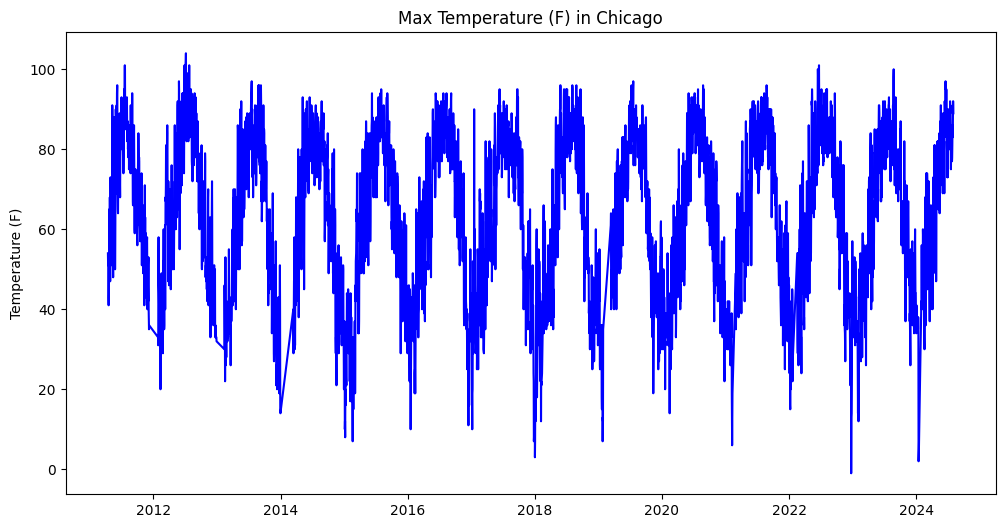

In [3]:
# Max daily temperatures at Midway Airport
plt.figure(figsize=(12,6))
plt.plot(chicago['date'], chicago['max_temp'], color='blue')
plt.ylabel('Temperature (F)')
plt.title('Max Temperature (F) in Chicago')
plt.show()

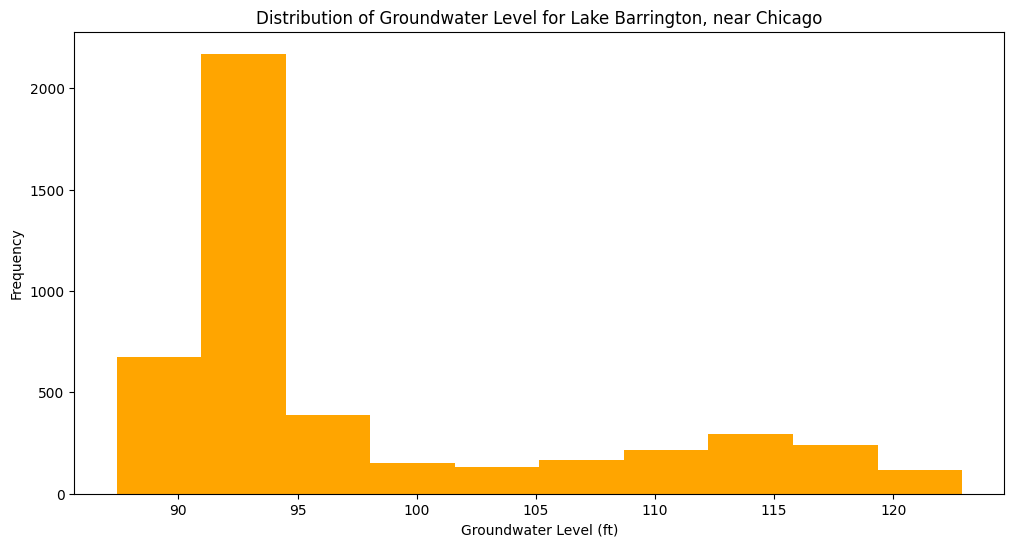

In [4]:
# Groundwater level (ft) near Chicago
plt.figure(figsize=(12,6))
plt.hist(chicago['gwl'], color='orange')
plt.xlabel('Groundwater Level (ft)')
plt.ylabel('Frequency')
plt.title('Distribution of Groundwater Level for Lake Barrington, near Chicago')
plt.show()

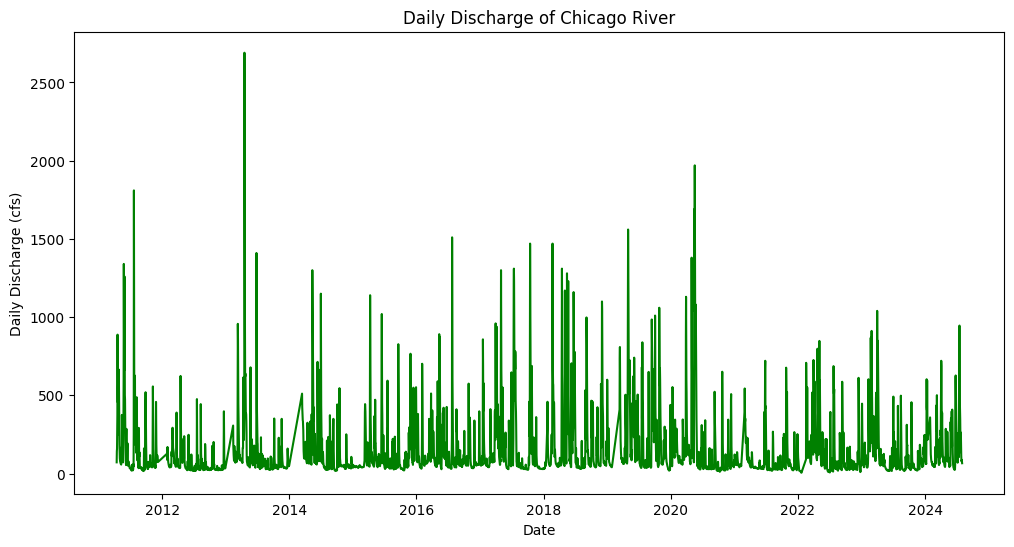

In [5]:
# Daily discharge for Chicago River at Niles, IL
plt.figure(figsize=(12, 6))
plt.plot(chicago['date'], chicago['daily_discharge_cfs'], color='green')
plt.xlabel('Date')
plt.ylabel('Daily Discharge (cfs)')
plt.title('Daily Discharge of Chicago River')
plt.show()

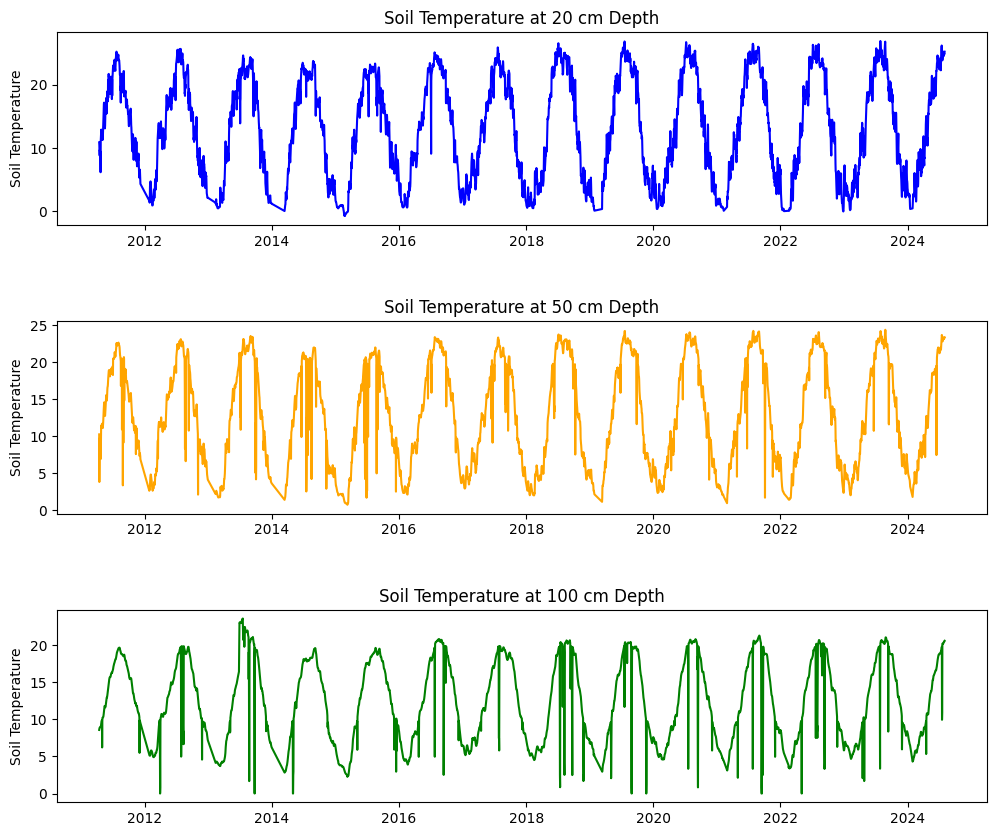

In [6]:
# Soil moisture at different depths in Champaign, the closest location to Chicago without large gaps in reporting
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(chicago['date'], chicago['st_20cm'], color='blue')
ax[0].set_title('Soil Temperature at 20 cm Depth')
ax[0].set_ylabel('Soil Temperature')

ax[1].plot(chicago['date'], chicago['st_50cm'], color='orange')
ax[1].set_title('Soil Temperature at 50 cm Depth')
ax[1].set_ylabel('Soil Temperature')

ax[2].plot(chicago['date'], chicago['st_100cm'], color='green')
ax[2].set_title('Soil Temperature at 100 cm Depth')
ax[2].set_ylabel('Soil Temperature')

plt.show()

## Additional Data Preparation with Principal Component Analysis

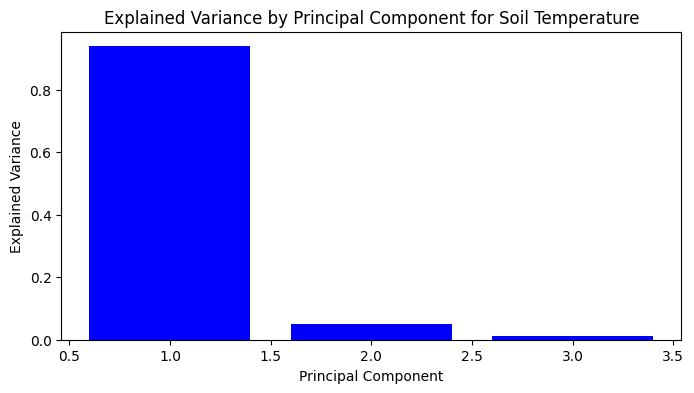

In [7]:
# Principal Component Analysis to reduce the three soil temperature variables to one PCA variable
X = chicago[['st_20cm','st_50cm','st_100cm']]

# Scale the three variables
X_scaled = StandardScaler().fit_transform(X)

# Conduct PCA
pca = PCA(n_components=3)
st_pca = pca.fit_transform(X_scaled)
st_pca_df = pd.DataFrame(data=st_pca, columns = ['pc1', 'pc2', 'pc3'])

# Plot explained variance to check if pc1 captures enough of variance to include
plt.figure(figsize=(8,4))
plt.bar(range(1,4), pca.explained_variance_ratio_, color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Component for Soil Temperature')
plt.show()

# Add first principle component to chicago dataframe and drop na rows
chicago['st_pca'] = st_pca_df['pc1']
chicago = chicago.dropna()

## Check for Correlation Between Explanatory Variables

<Axes: >

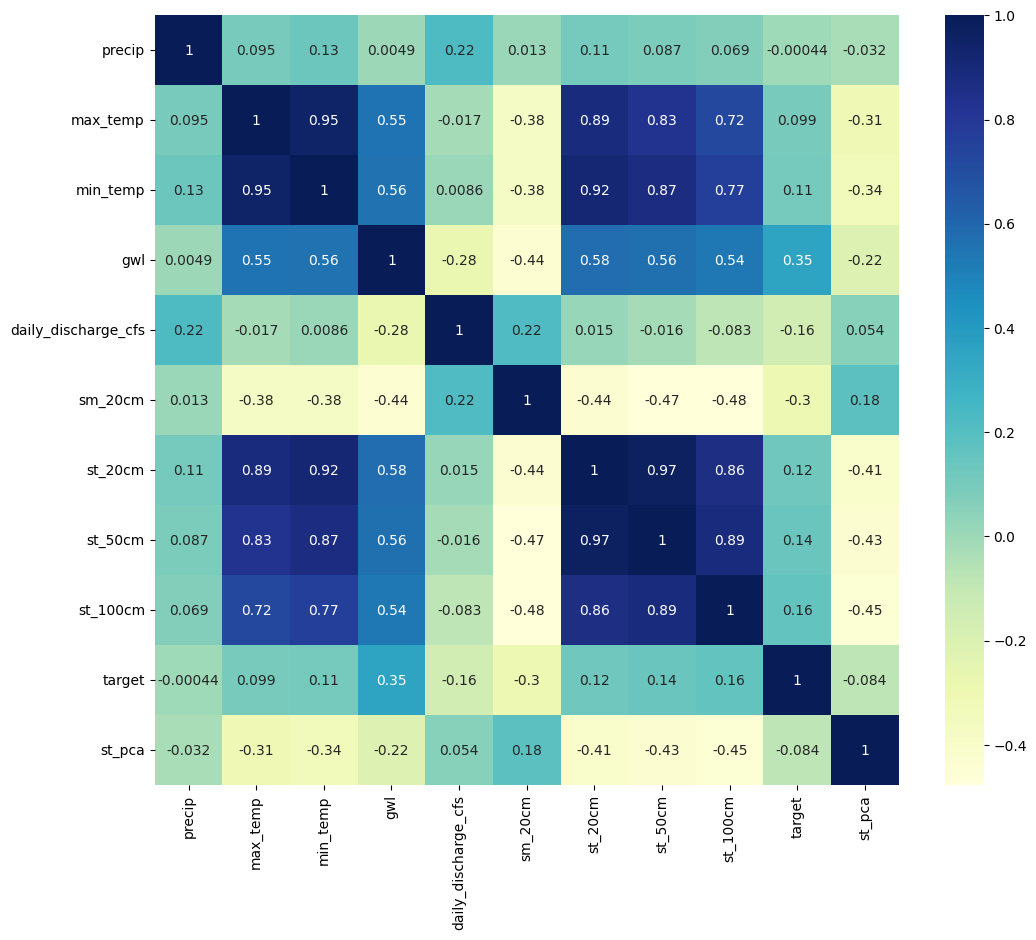

In [8]:
# Create heatmap of correlation between variables in the dataset
plt.figure(figsize=(12,10))
sns.heatmap(chicago.corr(numeric_only=True), cmap="YlGnBu", annot=True)

<Axes: >

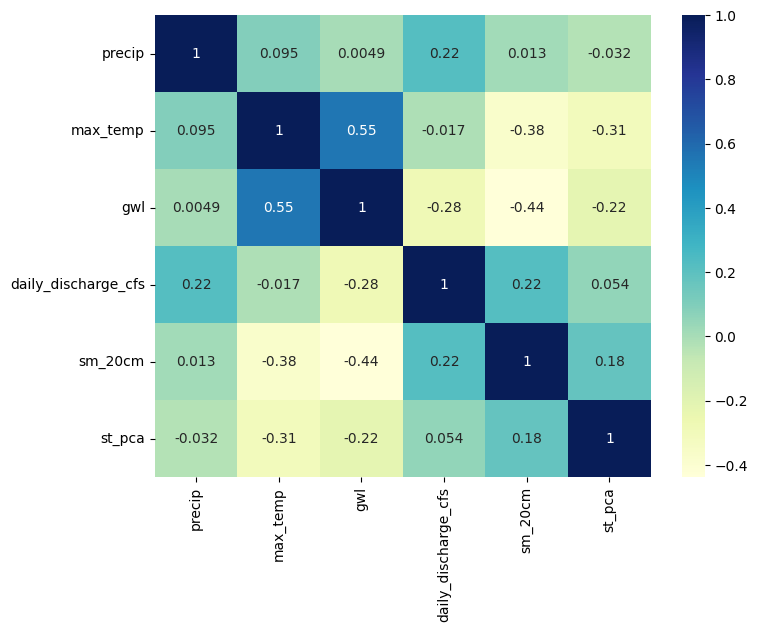

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(chicago[['precip','max_temp','gwl','daily_discharge_cfs','sm_20cm','st_pca']].corr(numeric_only=True), cmap="YlGnBu", annot=True)

## Unsupervised Learning: K-Means Clustering

In [10]:
# Assign feature and target variables
x_vars = ['precip','max_temp','gwl','daily_discharge_cfs','sm_20cm','st_pca']
X = chicago[x_vars]

# Standardize the feature variables
scaler= StandardScaler()
X = scaler.fit_transform(X)

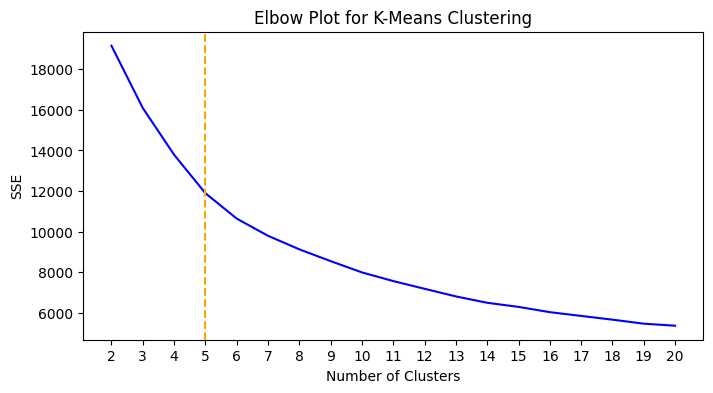

In [11]:
# Test K-Means with different number of clusters
sse = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=66)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Create elbow plot
plt.figure(figsize=(8,4))
plt.plot(range(2, 21), sse, color='blue')
plt.axvline(x=5, color='orange', linestyle='--')
plt.xticks(range(2, 21))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Plot for K-Means Clustering')
plt.show()

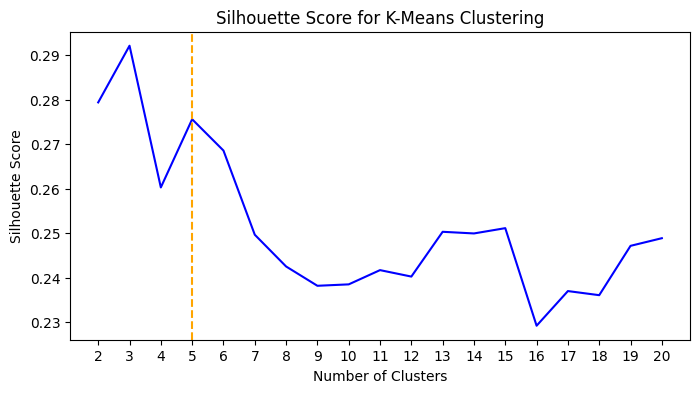

In [12]:
# Test K-Means with different number of clusters
silhouette = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='random', max_iter=300, n_init=10, random_state=66)
    sil = silhouette_score(X, kmeans.fit_predict(X))
    silhouette.append(sil)

# Plot silhouette score to see if there's a more noticable choice for number of clusters
plt.figure(figsize=(8,4))
plt.plot(range(2, 21), silhouette, color='blue')
plt.axvline(x=5, color='orange', linestyle='--')
plt.xticks(range(2, 21))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means Clustering')
plt.show()

In [13]:
# Build model with chosen number of clusters
kmeans = KMeans(n_clusters=5, init='random', max_iter=300, n_init=10, random_state=66)
kmeans.fit(X)

# Append cluster assignments to the chicago dataset
chicago['cluster'] = kmeans.labels_

# View updated dataset
display(chicago.head())

,date,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_20cm,st_20cm,st_50cm,st_100cm,target,st_pca,cluster
43,2011-04-15,0.17,54,40,92.59,71.9,0.386625,10.916667,10.237500,8.570833,0,0.321548,4
44,2011-04-16,0.13,51,36,92.50,143.0,0.393000,10.454167,3.787500,8.737500,0,0.370282,4
45,2011-04-17,0.08,52,34,92.08,159.0,0.404083,9.225000,7.275000,8.820833,0,0.501271,4
46,2011-04-18,0.34,43,33,91.99,241.0,0.400000,8.820833,9.562500,8.879167,0,0.666839,4
47,2011-04-19,0.81,41,36,92.07,373.0,0.413375,9.737500,9.754167,8.891667,0,0.742635,0


,cluster,date,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_20cm,st_20cm,st_50cm,st_100cm,target,st_pca
0,0,2017-07-03 09:08:34.285714176,1.329184,71.489796,56.367347,99.012449,297.817007,0.324981,17.194588,15.849831,14.427411,0.170068,-0.275635
1,1,2017-10-22 19:10:04.026845696,0.135302,63.305369,47.966443,92.160470,732.718121,0.367688,14.082181,13.321490,11.942374,0.023490,0.038635
2,2,2017-08-21 05:16:18.034681856,0.050260,82.172447,64.027938,112.881108,51.267813,0.271556,21.050428,19.554625,17.484003,0.335260,-0.561059
3,3,2017-07-01 06:02:58.512396800,0.058678,67.514050,50.785124,94.185231,109.282975,0.313198,15.421426,15.351886,14.793576,0.154545,-1.420737
4,4,2017-12-27 15:55:34.806629888,0.048956,47.661142,32.650706,92.343689,114.852014,0.362393,6.544821,7.171986,8.092128,0.093309,1.282558


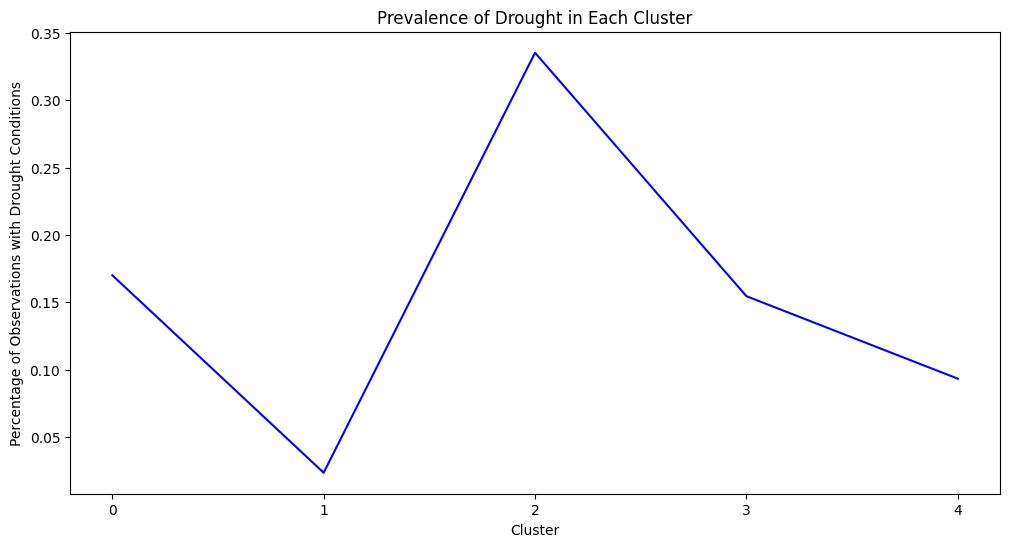

In [14]:
# Explore mean values of variables by cluster to see if there's noticeable differences
chicago_cluster = chicago.groupby('cluster').mean().reset_index()
chicago_cluster[['cluster','target','precip','max_temp','gwl','daily_discharge_cfs','sm_20cm','st_pca']]
display(chicago_cluster)

# Plot cluster by target
plt.figure(figsize=(12,6))
plt.plot(chicago_cluster['cluster'], chicago_cluster['target'], color='blue')
plt.xticks(range(0, 5))
plt.xlabel('Cluster')
plt.ylabel('Percentage of Observations with Drought Conditions')
plt.title('Prevalence of Drought in Each Cluster')
plt.show()

In [15]:
# Adding cluster labels to the dataframe
chicago_cent = pd.DataFrame(kmeans.cluster_centers_, columns=x_vars)
chicago_cent['cluster'] = chicago_cent.index

<Axes: >

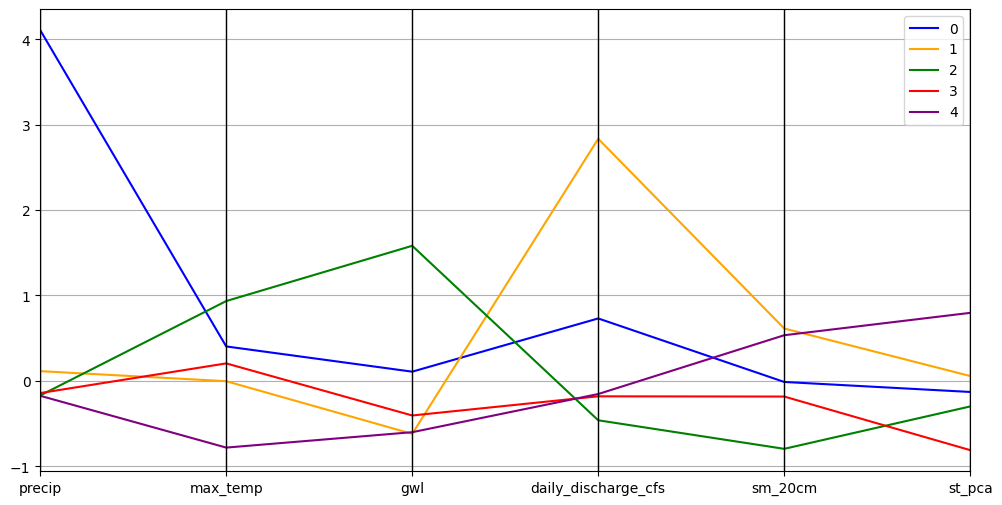

In [16]:
# Plot feature variables by cluster
plt.figure(figsize=(12,6))
pd.plotting.parallel_coordinates(chicago_cent, 'cluster', color=['blue','orange','green','red','purple'])

## Supervised Learning: Logistic Regression

In [17]:
# Assign feature and target variables
x_vars = ['precip','max_temp','gwl','daily_discharge_cfs','sm_20cm','st_pca']
X = chicago[x_vars]
y = chicago['target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

# Standardize the feature variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
logreg = LogisticRegression().fit(X_train, y_train)

In [18]:
# Display intercepts, coefficients, and R-squared value of model
print('Intercept: ', logreg.intercept_, 'Coefficients: ', logreg.coef_, 'R2 value: ', logreg.score(X_train, y_train))

Intercept:  [-1.9968265] Coefficients:  [[ 0.09600958 -0.64365158  0.89214965 -0.2722408  -0.58764835 -0.06411123]] R2 value:  0.8492912930286376


Accuracy: 85.55%


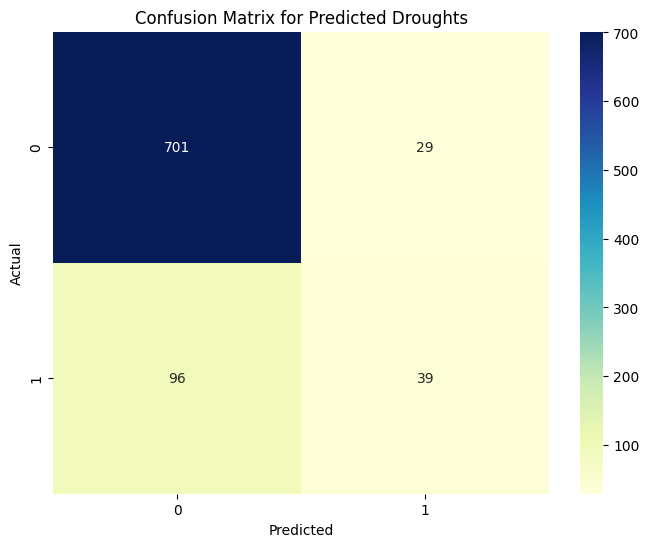

In [19]:
# Predict and calculate accuracy for the test data
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

print("Accuracy: {:.2f}%".format(accuracy * 100))
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="YlGnBu", annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Predicted Droughts')
plt.show()